Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	11


BorutaPy finished running.

Iteration: 	7 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	11
Selected features by Boruta:
['Temperature', 'Td dew point', 'GloblRad', 'UVI']
Selected features by Pearson Correlation:
['Temperature', 'RH', 'WS', 'PrecpHour', 'GloblRad', 'UVI', 'Cloud Amount']
Selected features by Mutual Information:
['WD', 'Cloud Amount', 'Temperature', 'RH', 'UVI', 'GloblRad']
Common selected features:
['GloblRad', 'Temperature', 'UVI', 'RH']


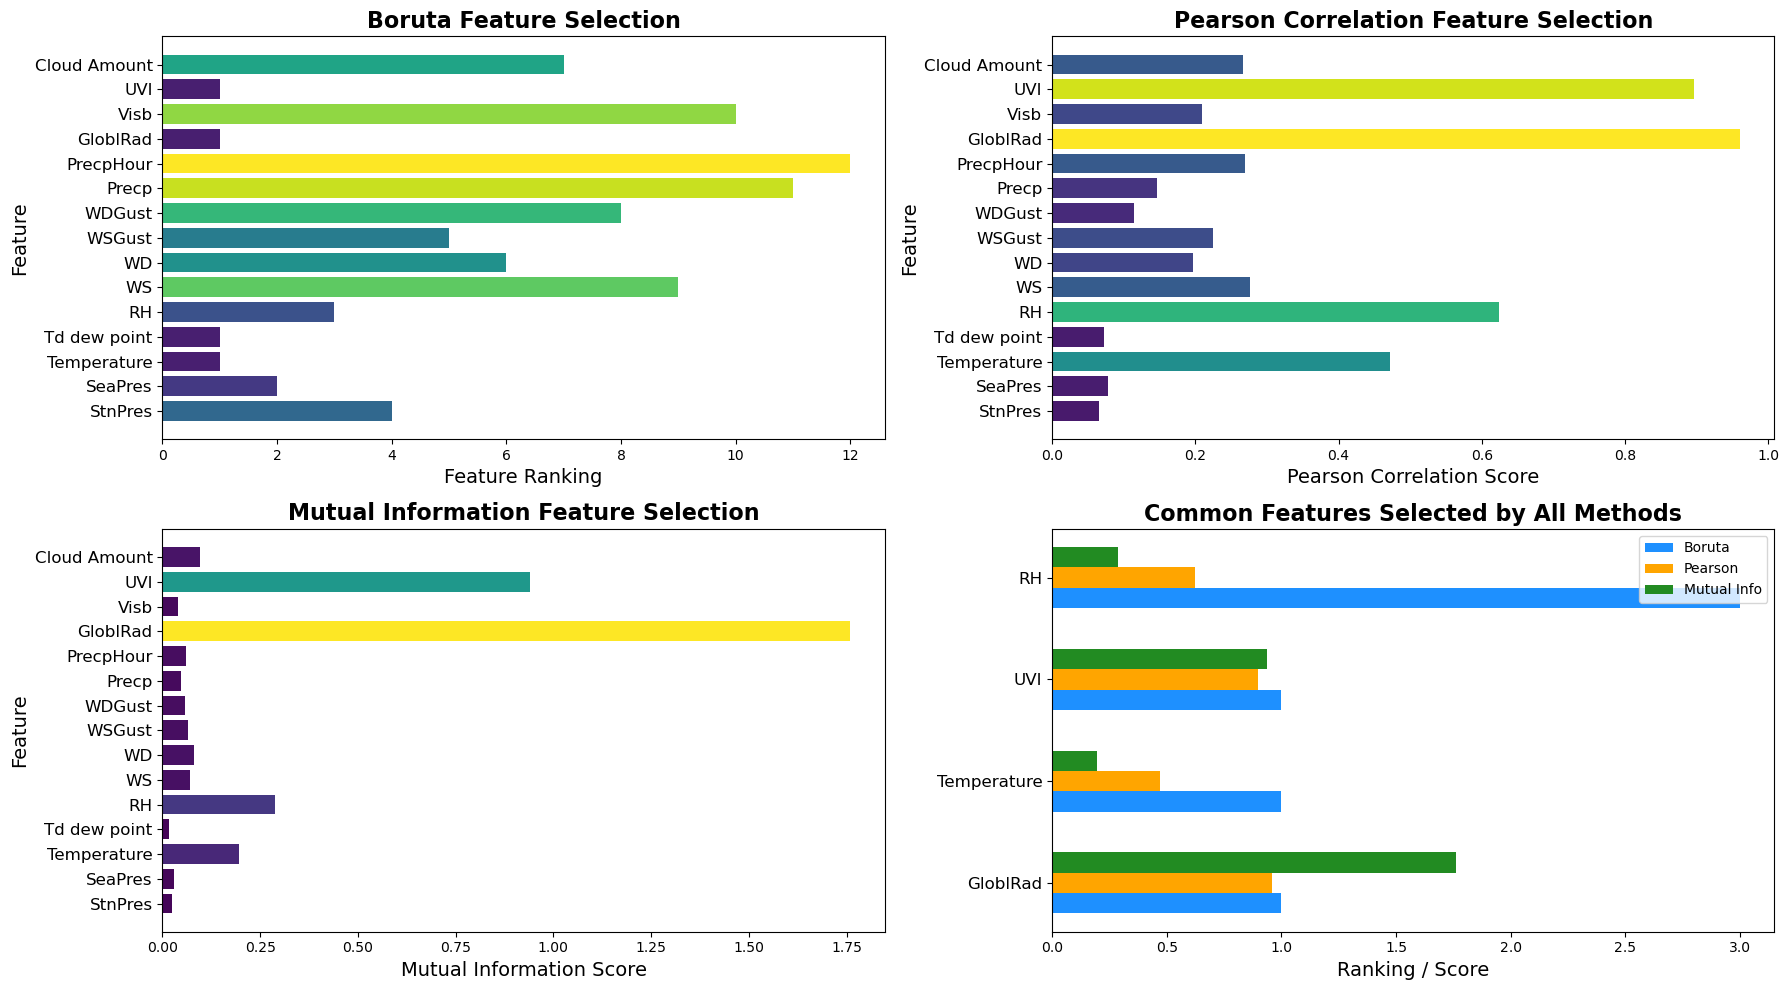

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from boruta import BorutaPy
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr

file_path = '20210219~20240731資料集.csv'
data = pd.read_csv(file_path)
time_column = data['Time']
data = data.drop(columns=['Time']).apply(pd.to_numeric, errors='coerce')
data.insert(0, 'Time', time_column)
data = data.fillna(method='bfill').fillna(method='ffill')
data.to_csv('processed_data.csv', index=False)

np.int = int
np.float = float
np.bool = bool

X = data.drop(columns=['Time', 'WH', 'SunShine'])
y = data['WH']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Boruta
rf = RandomForestRegressor(n_estimators=500, random_state=42)
boruta_selector = BorutaPy(rf, n_estimators='auto', alpha=0.1, verbose=2, random_state=42)
boruta_selector.fit(X_scaled, y)
boruta_features = X.columns[boruta_selector.support_].to_list()
print("Selected features by Boruta:")
print(boruta_features)

# Pearson correlation
pearson_correlations = [pearsonr(X_scaled[:, X.columns.get_loc(col)], y)[0] for col in X.columns]
pearson_features = [col for col, corr in zip(X.columns, pearson_correlations) if abs(corr) > 0.25]
print("Selected features by Pearson Correlation:")
print(pearson_features)

# Mutual information
mutual_info = mutual_info_regression(X_scaled, y)
mutual_info_features = X.columns[np.argsort(mutual_info)[-6:]].to_list()
print("Selected features by Mutual Information:")
print(mutual_info_features)

# 取交集
common_features = list(set(boruta_features) & set(pearson_features) & set(mutual_info_features))
if 'RH' not in common_features:
    common_features.append('RH')
print("Common selected features:")
print(common_features)

fig, axs = plt.subplots(2, 2, figsize=(18, 10))

def plot_boruta_process(ax, selector, X):
    rankings = selector.ranking_
    colors = cm.viridis(rankings / max(rankings))
    ax.barh(range(len(rankings)), rankings, align='center', color=colors)
    ax.set_yticks(range(len(rankings)))
    ax.set_yticklabels([X.columns[i] for i in range(len(rankings))], fontsize=12)
    ax.set_xlabel('Feature Ranking', fontsize=14)
    ax.set_ylabel('Feature', fontsize=14)
    ax.set_title('Boruta Feature Selection', fontsize=16, fontweight='bold')

plot_boruta_process(axs[0, 0], boruta_selector, X)

def plot_pearson_correlation(ax, correlations, feature_names):
    rankings = np.abs(correlations)
    colors = cm.viridis(rankings / max(rankings))
    ax.barh(range(len(rankings)), rankings, align='center', color=colors)
    ax.set_yticks(range(len(rankings)))
    ax.set_yticklabels(feature_names, fontsize=12)
    ax.set_xlabel('Pearson Correlation Score', fontsize=14)
    ax.set_ylabel('Feature', fontsize=14)
    ax.set_title('Pearson Correlation Feature Selection', fontsize=16, fontweight='bold')

plot_pearson_correlation(axs[0, 1], pearson_correlations, X.columns)

def plot_mutual_information(ax, mutual_info, feature_names):
    rankings = mutual_info
    colors = cm.viridis(rankings / max(rankings))
    ax.barh(range(len(rankings)), rankings, align='center', color=colors)
    ax.set_yticks(range(len(rankings)))
    ax.set_yticklabels(feature_names, fontsize=12)
    ax.set_xlabel('Mutual Information Score', fontsize=14)
    ax.set_ylabel('Feature', fontsize=14)
    ax.set_title('Mutual Information Feature Selection', fontsize=16, fontweight='bold')

plot_mutual_information(axs[1, 0], mutual_info, X.columns)

def plot_common_features(ax, common_features, boruta_selector, pearson_correlations, mutual_info):
    common_indices = [X.columns.get_loc(feature) for feature in common_features]
    boruta_ranking = boruta_selector.ranking_[common_indices]
    pearson_ranking = np.abs([pearson_correlations[i] for i in common_indices])
    mutual_info_ranking = [mutual_info[i] for i in common_indices]

    index = np.arange(len(common_features))
    bar_width = 0.2

    bars1 = ax.barh(index, boruta_ranking, bar_width, label='Boruta', color='dodgerblue')
    bars2 = ax.barh(index + bar_width, pearson_ranking, bar_width, label='Pearson', color='orange')
    bars3 = ax.barh(index + 2 * bar_width, mutual_info_ranking, bar_width, label='Mutual Info', color='forestgreen')

    ax.set_yticks(index + bar_width)
    ax.set_yticklabels(common_features, fontsize=12)
    ax.legend()

    ax.set_xlabel('Ranking / Score', fontsize=14)
    ax.set_title('Common Features Selected by All Methods', fontsize=16, fontweight='bold')
    ax.legend(loc='upper right')

plot_common_features(axs[1, 1], common_features, boruta_selector, pearson_correlations, mutual_info)

plt.tight_layout()
plt.show()

In [2]:
from graphviz import Digraph

dot = Digraph(comment='Feature Selection Process')

dot.node('A', 'Data Preprocessing', shape='box', style='filled', color='lightblue', fontsize='14', fontname='Times-Roman')
dot.node('B', 'Boruta Feature Selection', shape='box', style='filled', color='lightgreen', fontsize='14', fontname='Times-Roman')
dot.node('C', 'Pearson Correlation Coefficient', shape='box', style='filled', color='lightgreen', fontsize='14', fontname='Times-Roman')
dot.node('D', 'Mutual Information', shape='box', style='filled', color='lightgreen', fontsize='14', fontname='Times-Roman')
dot.node('E', 'Intersection of Selected Features', shape='ellipse', style='filled', color='yellow', fontsize='14', fontname='Times-Roman')
dot.node('F', 'Final Selected Features', shape='box', style='filled', color='lightcoral', fontsize='14', fontname='Times-Roman')

dot.edge('A', 'B', style='dashed', fontsize='12', fontname='Times-Roman')
dot.edge('A', 'C', label=' Step_1', style='dashed', fontsize='12', fontname='Times-Roman')
dot.edge('A', 'D', style='dashed', fontsize='12', fontname='Times-Roman')
dot.edge('B', 'E', fontsize='12', fontname='Times-Roman')
dot.edge('C', 'E', label=' Step_2', fontsize='12', fontname='Times-Roman')
dot.edge('D', 'E', fontsize='12', fontname='Times-Roman')
dot.edge('E', 'F', label=' Step_3', style='bold', fontsize='12', fontname='Times-Roman')

dot.render('feature_selection_process', format='png', view=True)

'feature_selection_process.png'